In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Preprocessing the data

In [2]:
train_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Train"
test_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Test"
valid_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Validation"
train_dir_augmented = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Train_augmented"

# Setup data inputs
IMG_SIZE = 128

#import data from directory
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = True,
                                                                seed = 42)

train_data_augmented = tf.keras.preprocessing.image_dataset_from_directory(train_dir_augmented,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = True,
                                                                seed = 42)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = False) # don't shuffle test data for prediction analysis

valid_data = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = False) # don't shuffle test data for prediction analysis
train_data

Found 19173 files belonging to 7 classes.
Found 23846 files belonging to 7 classes.
Found 2030 files belonging to 7 classes.
Found 2030 files belonging to 7 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

In [26]:
class_names = train_data.class_names
class_names

['Atelectasis',
 'Effusion',
 'Infiltration',
 'Mass',
 'No_finding',
 'Nodule',
 'Pneumothorax']

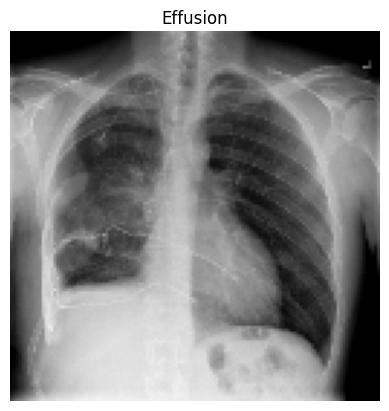

In [4]:
train_one_sample = train_data.take(1) # samples from the training data
for image, label in train_one_sample:
    plt.imshow(image[0]/255.0)
    plt.title(class_names[tf.argmax(label,axis=1)[0].numpy()])
    plt.axis(False)

## Preprocessing the dataset

In [5]:
#Creating a function to preprocess the images
def preprocess_img(image, label):
  """
  Converts image datatype from 'uint8' -> 'float32' 
  """
  return tf.cast(image, tf.float32), label 

In [6]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE) 
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(map_func = preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size = tf.data.AUTOTUNE)

# Map prepreprocessing function to validation data
valid_data = valid_data.map(map_func = preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
valid_data = valid_data.prefetch(buffer_size = tf.data.AUTOTUNE)

# Map prepreprocessing function to augmented training data
train_data_augmented = train_data_augmented.map(map_func = preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
train_data_augmented = train_data_augmented.prefetch(buffer_size = tf.data.AUTOTUNE)

# Creating checkpoint callback

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='cnn_best_model.h5',
    save_weights_only=False,  
    monitor='val_accuracy',  
    save_best_only=True,  
    verbose=1  
)

# Creating the model 

In [19]:
from tensorflow.keras import layers, Model, regularizers

inputs = layers.Input(shape=(128,128,3))
x = layers.Rescaling(1/.255)(inputs)


x = layers.Conv2D(128, kernel_size=5, padding='same', activation='relu')(x)
x = layers.Conv2D(128, kernel_size=5, padding='same', activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.AveragePooling2D()(x)

x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.AveragePooling2D()(x)

x = layers.Conv2D(32, kernel_size=2, padding='same', activation='relu')(x)
x = layers.Conv2D(32, kernel_size=2, padding='same', activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.AveragePooling2D(pool_size=(3,3))(x)

x = layers.Flatten()(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(len(class_names), activation='softmax')(x)

model_cnn = tf.keras.Model(inputs, outputs)

model_cnn.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [21]:
import random 
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
  
history_cnn = model_cnn.fit(
                            train_data_augmented,
                            epochs=13,
                            validation_data=valid_data,
                            validation_steps=len(valid_data),
                            #callbacks=[checkpoint_callback]
)

Epoch 1/3


2024-01-17 16:56:46.265680: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


746/746 [==============================] - ETA: 0s - loss: 1.5209 - accuracy: 0.4074
Epoch 1: val_accuracy improved from 0.24680 to 0.24975, saving model to cnn_best_model.h5
746/746 [==============================] - 166s 220ms/step - loss: 1.5209 - accuracy: 0.4074 - val_loss: 1.9325 - val_accuracy: 0.2498
Epoch 2/3


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


746/746 [==============================] - ETA: 0s - loss: 1.4834 - accuracy: 0.4249
Epoch 2: val_accuracy did not improve from 0.24975
746/746 [==============================] - 168s 223ms/step - loss: 1.4834 - accuracy: 0.4249 - val_loss: 1.9933 - val_accuracy: 0.2458
Epoch 3/3
746/746 [==============================] - ETA: 0s - loss: 1.4587 - accuracy: 0.4353
Epoch 3: val_accuracy did not improve from 0.24975
746/746 [==============================] - 164s 218ms/step - loss: 1.4587 - accuracy: 0.4353 - val_loss: 2.0016 - val_accuracy: 0.2360


# Evaluate the model

In [19]:
model_cnn = tf.keras.models.load_model(r'C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\6_saved_models\cnn_best_model.h5')
model_cnn.evaluate(test_data)

64/64 [==============================] - 120s 2s/step - loss: 1.9184 - accuracy: 0.2483


[1.918379306793213, 0.24827586114406586]

## Confusion matrix

In [25]:
from helper_functions import plot_confusion_matrix

# Create test labels and predictions
test_labels = []
for images, labels in test_data.unbatch():
  test_labels.append(tf.argmax(labels).numpy())
test_pred_probs = model_cnn.predict(test_data)
test_predictions = tf.argmax(test_pred_probs, axis=1)

64/64 [==============================] - 86s 1s/step


array([[0.53103448, 0.10689655, 0.12413793, 0.01724138, 0.13103448,
        0.02068966, 0.06896552],
       [0.23103448, 0.37241379, 0.17931034, 0.02413793, 0.08965517,
        0.0137931 , 0.08965517],
       [0.26206897, 0.14827586, 0.19655172, 0.03448276, 0.23103448,
        0.04137931, 0.0862069 ],
       [0.31034483, 0.20344828, 0.14137931, 0.03793103, 0.18965517,
        0.02758621, 0.08965517],
       [0.26896552, 0.13793103, 0.13103448, 0.04482759, 0.27241379,
        0.04137931, 0.10344828],
       [0.2       , 0.09310345, 0.12413793, 0.05517241, 0.37931034,
        0.05172414, 0.09655172],
       [0.1862069 , 0.14482759, 0.14137931, 0.07241379, 0.15172414,
        0.02758621, 0.27586207]])

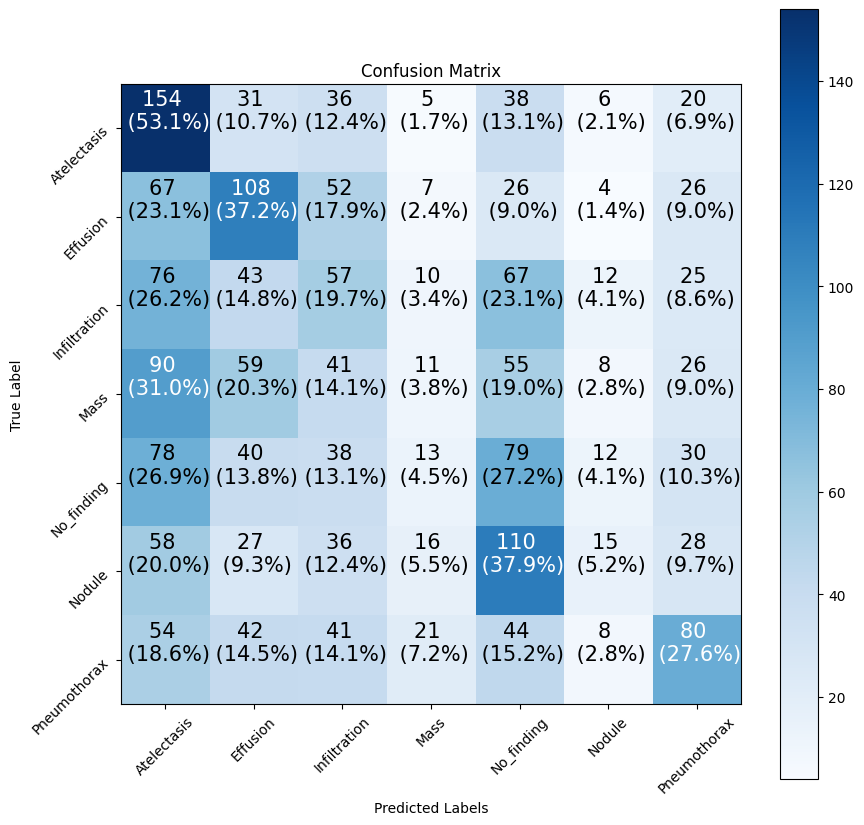

In [27]:
plot_confusion_matrix(test_labels, test_predictions, class_names)